In [0]:
# ! pip install pydicom nibabel SimpleITK pyradiomics

In [0]:
from __future__ import print_function
import os, sys
import logging
import six, csv
import numpy as np
import pandas as pd
import glob
import tqdm

# import matplotlib
# matplotlib.use("AGG")
import matplotlib.pyplot as plt

import pydicom as dicom
import nibabel as nib

import SimpleITK as sitk

import radiomics
from radiomics import featureextractor
from radiomics import firstorder, glcm, imageoperations, shape, glrlm, glszm

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
cd "/content/gdrive/My Drive/projects/ClinicAI/FinalProject/"

/content/gdrive/My Drive/projects/ClinicAI/FinalProject


In [0]:
t1_label1 = np.load("t1_label1.npy")
t1_label2 = np.load("t1_label2.npy")
t1_label4 = np.load("t1_label4.npy")
t1ce_label1 = np.load("t1ce_label1.npy")
t1ce_label2 = np.load("t1ce_label2.npy")
t1ce_label4 = np.load("t1ce_label4.npy")
t2_label1 = np.load("t2_label1.npy")
t2_label2 = np.load("t2_label2.npy")
t2_label4 = np.load("t2_label4.npy")
flair_label1 = np.load("flair_label1.npy")
flair_label2 = np.load("flair_label2.npy")
flair_label4 = np.load("flair_label4.npy")

In [0]:
featureName = np.load("radiomics_featureName.npy")

In [0]:
np.savez_compressed("radiomics_features.npz", t1_1=t1_label1, t1_2=t1_label2, t1_4=t1_label4, t1ce_1=t1ce_label1, t1ce_2=t1ce_label2, t1ce_4=t1ce_label4,
                   t2_1=t2_label1, t2_2=t2_label2, t2_4=t2_label4, flair_1=flair_label1, flair_2=flair_label2, flair_4=flair_label4, featureName=featureName)

In [0]:
radios = np.load("radiomics_features.npz")

In [17]:
radios["featureName"].shape

(1130,)

In [0]:
radiomics_features = np.concatenate((t1_label1,t1_label2,t1_label4, \
                                     t1ce_label1,t1ce_label2,t1ce_label4, \
                                     t2_label1,t2_label2,t2_label4, \
                                     flair_label1, flair_label2, flair_label4), axis=1)

In [21]:
radiomics_features.shape

(39, 13560)

In [53]:
for name in featureName:
    print(name)

original_shape_Elongation
original_shape_Flatness
original_shape_LeastAxisLength
original_shape_MajorAxisLength
original_shape_Maximum2DDiameterColumn
original_shape_Maximum2DDiameterRow
original_shape_Maximum2DDiameterSlice
original_shape_Maximum3DDiameter
original_shape_MeshVolume
original_shape_MinorAxisLength
original_shape_Sphericity
original_shape_SurfaceArea
original_shape_SurfaceVolumeRatio
original_shape_VoxelVolume
original_firstorder_10Percentile
original_firstorder_90Percentile
original_firstorder_Energy
original_firstorder_Entropy
original_firstorder_InterquartileRange
original_firstorder_Kurtosis
original_firstorder_Maximum
original_firstorder_MeanAbsoluteDeviation
original_firstorder_Mean
original_firstorder_Median
original_firstorder_Minimum
original_firstorder_Range
original_firstorder_RobustMeanAbsoluteDeviation
original_firstorder_RootMeanSquared
original_firstorder_Skewness
original_firstorder_TotalEnergy
original_firstorder_Uniformity
original_firstorder_Variance
o

In [0]:
y = np.load("y_survival.npy")

In [25]:
y

array([1155,  614,  698,  439,  180,  616,  375,  152,  522,  120,  172,
        726,  510,  453,  350,  788,  114,  169, 1767, 1283,  168,  473,
        401,  515,  287,  106,  139,  331,  448,  376, 1592,  660,  576,
        465,  503,  495,  486,  368,   50])

In [0]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel, RFE
from sklearn.linear_model import Lasso, LassoCV, LinearRegression, LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor

# from sklearn.decomposition import PCA

In [0]:
x_train, x_test, y_train, y_test = train_test_split(radiomics_features, y, test_size=0.21, random_state=42)

In [27]:
x_train.shape, y_train.shape

((30, 13560), (30,))

In [0]:
rf = RandomForestRegressor(n_estimators=200, random_state=42, n_jobs=-1, oob_score=True)

In [0]:
sfm = SelectFromModel(rf, threshold=1e-6)


In [40]:
sfm.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=None,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=1,
                                                min_samples_split=2,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=200, n_jobs=-1,
                                                oob_score=True, random_state=42,
                                                verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False, threshold=1e-06)

In [0]:
x_select = sfm.transform(x_train)

In [42]:
x_select.shape

(30, 2036)

In [0]:
sel_idx = sfm.get_support(indices=True)

In [0]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [91]:
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': ['auto', 'sqrt'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [92]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 33.3min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 59.8min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=RandomForestRegressor(bootstrap=True,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators='warn',
                                                   n_jobs=None, oob_score=False,
                                                   random_sta...


In [93]:
rf_random.best_params_

{'bootstrap': True,
 'max_depth': 40,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 2000}

In [0]:
select_rf = rf_random.best_estimator_

In [97]:
select_rf.set_params(oob_score=True, random_state=42, n_jobs=-1)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=40,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=2, min_samples_split=10,
                      min_weight_fraction_leaf=0.0, n_estimators=2000,
                      n_jobs=-1, oob_score=True, random_state=42, verbose=0,
                      warm_start=False)

In [0]:
sfm = SelectFromModel(select_rf, threshold=5*1e-4)

In [116]:
sfm.fit(x_train, y_train)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse',
                                                max_depth=40,
                                                max_features='auto',
                                                max_leaf_nodes=None,
                                                min_impurity_decrease=0.0,
                                                min_impurity_split=None,
                                                min_samples_leaf=2,
                                                min_samples_split=10,
                                                min_weight_fraction_leaf=0.0,
                                                n_estimators=2000, n_jobs=-1,
                                                oob_score=True, random_state=42,
                                                verbose=0, warm_start=False),
                max_features=None, norm_order=1, prefit=False,
                threshold=0.0005)

In [0]:
x_select = sfm.transform(x_train)

In [118]:
x_select.shape

(30, 472)

In [0]:
np.save("x_select_rf_threshold_5e-4", x_select)

In [0]:
for i in sel_idx:
    group = i//1130
    if(group %3 == 0):
        label = 1
    elif(group %3 == 1):
        label = 2 
    else:
        label = 4
    
    if(group // 3 == 0):
        modality = 't1'
    elif(group // 3 == 1):
        modality = 't1ce'
    elif(group // 3 == 2):
        modality = 't2'
    else:
        modality = 'flair'
    print(modality, label, featureName[i%1130])

In [0]:
# for i in range(model.feature_importances_.shape[0]):
#     group = int(i/1130)
#     if(model.feature_importances_[i] == 0):
#         continue
#     if(group %3 == 0):
#         label = 1
#     elif(group %3 == 1):
#         label = 2 
#     else:
#         label = 4
        
#     if(group // 3 == 0):
#         modality = 't1'
#     elif(group // 3 == 1):
#         modality = 't1ce'
#     elif(group // 3 == 2):
#         modality = 't2'
#     else:
#         modality = 'flair'
#     print(modality, label, featureName[i%1130], model.feature_importances_[i])

In [0]:
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, Input, GRU, Bidirectional, GlobalAveragePooling1D, Concatenate
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.optimizers import Adam, SGD, RMSprop
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [0]:
## Train
def dnn(input_size):
    inputs = Input((input_size,))
    x = Dense(256, kernel_initializer='normal', activation='relu')(inputs)
#     x = Dense(256, kernel_initializer='normal', activation='relu')(x)
    outputs = Dense(1, kernel_initializer='normal')(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [85]:
DNN = dnn(2036)
DNN.compile(loss='mse', optimizer=RMSprop(lr=1e-4))
DNN.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 2036)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 256)               521472    
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 257       
Total params: 521,729
Trainable params: 521,729
Non-trainable params: 0
_________________________________________________________________


In [86]:
history = DNN.fit(x_select, y_train, batch_size=4, epochs=150, validation_split=0.1)

Train on 27 samples, validate on 3 samples
Epoch 1/150
27/27 [==============================] - 0s 12ms/step - loss: 24768296859467776.0000 - val_loss: 691234519646208.0000
Epoch 2/150
27/27 [==============================] - 0s 764us/step - loss: 15955119451561682.0000 - val_loss: 2675942061244416.0000
Epoch 3/150
27/27 [==============================] - 0s 761us/step - loss: 9535927082733720.0000 - val_loss: 1410037763276800.0000
Epoch 4/150
27/27 [==============================] - 0s 962us/step - loss: 5632497262312865.0000 - val_loss: 1863621072125952.0000
Epoch 5/150
27/27 [==============================] - 0s 946us/step - loss: 7256111281884122.0000 - val_loss: 126171333263360.0000
Epoch 6/150
27/27 [==============================] - 0s 747us/step - loss: 6425805828070514.0000 - val_loss: 637220406951936.0000
Epoch 7/150
27/27 [==============================] - 0s 771us/step - loss: 4347333881733423.5000 - val_loss: 54092181274624.0000
Epoch 8/150
27/27 [=========================

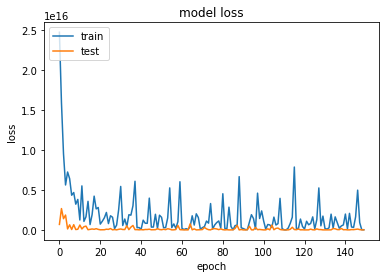

In [87]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [88]:
y_pred = DNN.predict(sfm.transform(x_test))
y_pred

array([[  4138074.],
       [  1306732.],
       [ -4800352.],
       [   274000.],
       [ 29032256.],
       [-25280288.],
       [  -373504.],
       [-23695120.],
       [  1607152.]], dtype=float32)

In [65]:
y_test

array([ 465,  486,  180,  453, 1592,  139,  375,  331,  287])

In [0]:
from sklearn.metrics import mean_squared_error as mse

In [0]:
mse(y_test, y_pred)

225169.43169134794